In [36]:
# Get the data and take a look at it
import pandas as pd
import sqlite3

# Connect to the local SQLite database
conn = sqlite3.connect('../cms_synthetic_claims/cms_synthetic_claims.db')

# Run the PRAGMA table_info command for each table
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
for table in tables['name']:
    info = pd.read_sql_query(f"PRAGMA table_info({table});", conn)
    print(f"Table: {table}")
    print(info)
    print()

df_inpatient_claims = pd.read_sql_query("SELECT * FROM raw_cms_claims GROUP BY CLM_ID;", conn)
conn.close()

Table: raw_cms_claims
     cid                         name       type  notnull dflt_value  pk
0      0                      BENE_ID    INTEGER        0       None   0
1      1                       CLM_ID    INTEGER        0       None   0
2      2   NCH_NEAR_LINE_REC_IDENT_CD       TEXT        0       None   0
3      3              NCH_CLM_TYPE_CD    INTEGER        0       None   0
4      4                  CLM_FROM_DT  TIMESTAMP        0       None   0
..   ...                          ...        ...      ...        ...  ..
192  192     CLM_UNCOMPD_CARE_PMT_AMT       REAL        0       None   0
193  193                 CLM_LINE_NUM    INTEGER        0       None   0
194  194                     REV_CNTR    INTEGER        0       None   0
195  195                     HCPCS_CD       TEXT        0       None   0
196  196  REV_CNTR_DDCTBL_COINSRNC_CD       REAL        0       None   0

[197 rows x 6 columns]

Table: raw_cms_beneficiary_2025
     cid               name       type  notnu

In [37]:
# Thats a lot of data, just take a subset of the columns

# Select a subset of columns to keep
columns_to_keep = [
    'BENE_ID', # unique beneficiary identifier
    'CLM_ID', # unique claim identifier
    'CLM_FROM_DT', # claim start date
    'CLM_THRU_DT', # claim through date
]

# we need claim data, but we want to add that a specific way

# what to do about 1 bene having multiple claims?

df_inpatient_subset = df_inpatient_claims[columns_to_keep].copy()

# Add a new column for the number of days between CLM_FROM_DT and CLM_THRU_DT
df_inpatient_subset['CLM_NUM_DAYS'] = (
    pd.to_datetime(df_inpatient_subset['CLM_THRU_DT']) - pd.to_datetime(df_inpatient_subset['CLM_FROM_DT'])
).dt.days



In [38]:
# df_inpatient_subset.head()
df_inpatient_subset

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,CLM_NUM_DAYS
0,-10000010288010,-10000931486024,2017-06-11 00:00:00,2017-06-11 00:00:00,0
1,-10000010288008,-10000931485971,2021-09-13 00:00:00,2021-09-16 00:00:00,3
2,-10000010288008,-10000931485969,2021-08-22 00:00:00,2021-08-23 00:00:00,1
3,-10000010288008,-10000931485967,2020-10-23 00:00:00,2020-10-23 00:00:00,0
4,-10000010288008,-10000931485965,2020-01-08 00:00:00,2020-01-14 00:00:00,6
...,...,...,...,...,...
20862,-10000010254656,-10000930038163,2018-03-17 00:00:00,2018-03-17 00:00:00,0
20863,-10000010254656,-10000930038162,2017-01-14 00:00:00,2017-01-14 00:00:00,0
20864,-10000010254653,-10000930038031,2017-05-09 00:00:00,2017-05-10 00:00:00,1
20865,-10000010254653,-10000930038030,2015-09-24 00:00:00,2015-09-24 00:00:00,0


In [39]:
# add the diagnosis codes
# Add all ICD_DGNS_CD1-25 and CLM_POA_IND_SW1-25 columns from df_inpatient_claims to df_inpatient_subset

# IGNORE POA FOR NOW, MAYBE LATER

# Identify the columns to add
diagnosis_cols = [f'ICD_DGNS_CD{i}' for i in range(1, 26)]
# poa_cols = [f'CLM_POA_IND_SW{i}' for i in range(1, 26)]

# Only keep columns that exist in df_inpatient_claims
diagnosis_cols = [col for col in diagnosis_cols if col in df_inpatient_claims.columns]
# poa_cols = [col for col in poa_cols if col in df_inpatient_claims.columns]

# Add the principal diagnosis code column
df_inpatient_subset['PRNCPAL_DGNS_CD'] = df_inpatient_claims['PRNCPAL_DGNS_CD'].values

# Create a new column that concatenates all diagnosis codes for each claim into a single string
# df_inpatient_subset['ALL_DGNS_CODES'] = df_inpatient_claims[diagnosis_cols].astype(str).agg('|'.join, axis=1)

# Add these columns to the subset DataFrame
df_inpatient_subset = pd.concat(
    # [df_inpatient_subset, df_inpatient_claims[diagnosis_cols + poa_cols].reset_index(drop=True)],
    # axis=1
    [df_inpatient_subset, df_inpatient_claims[diagnosis_cols].reset_index(drop=True)],
    axis=1
)

In [40]:
# df_inpatient_subset.head()
df_inpatient_subset

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,CLM_NUM_DAYS,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,...,ICD_DGNS_CD16,ICD_DGNS_CD17,ICD_DGNS_CD18,ICD_DGNS_CD19,ICD_DGNS_CD20,ICD_DGNS_CD21,ICD_DGNS_CD22,ICD_DGNS_CD23,ICD_DGNS_CD24,ICD_DGNS_CD25
0,-10000010288010,-10000931486024,2017-06-11 00:00:00,2017-06-11 00:00:00,0,S93409,S93409,I050,Z608,G8929,...,None,None,None,None,None,None,None,None,None,None
1,-10000010288008,-10000931485971,2021-09-13 00:00:00,2021-09-16 00:00:00,3,T50901A,Z608,Z733,F0280,T50901A,...,None,None,None,None,None,None,None,None,None,None
2,-10000010288008,-10000931485969,2021-08-22 00:00:00,2021-08-23 00:00:00,1,T50901A,Z608,Z733,G309,T50901A,...,None,None,None,None,None,None,None,None,None,None
3,-10000010288008,-10000931485967,2020-10-23 00:00:00,2020-10-23 00:00:00,0,T50901A,Z733,F0280,T50901A,J329,...,None,None,None,None,None,None,None,None,None,None
4,-10000010288008,-10000931485965,2020-01-08 00:00:00,2020-01-14 00:00:00,6,T50901A,T7432X,T50901A,J329,R931,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20862,-10000010254656,-10000930038163,2018-03-17 00:00:00,2018-03-17 00:00:00,0,Z3480,Z5989,Z5941,G40909,R569,...,None,None,None,None,None,None,None,None,None,None
20863,-10000010254656,-10000930038162,2017-01-14 00:00:00,2017-01-14 00:00:00,0,S8290X,S8290X,G40909,R569,Z8669,...,None,None,None,None,None,None,None,None,None,None
20864,-10000010254653,-10000930038031,2017-05-09 00:00:00,2017-05-10 00:00:00,1,T7432X,T7432X,E669,C50929,None,...,None,None,None,None,None,None,None,None,None,None
20865,-10000010254653,-10000930038030,2015-09-24 00:00:00,2015-09-24 00:00:00,0,Z3480,T7432X,E669,C50919,None,...,None,None,None,None,None,None,None,None,None,None


In [41]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_inpatient_subset, test_size=0.2, random_state=42)

In [42]:
train_df
# test_df

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,CLM_NUM_DAYS,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,...,ICD_DGNS_CD16,ICD_DGNS_CD17,ICD_DGNS_CD18,ICD_DGNS_CD19,ICD_DGNS_CD20,ICD_DGNS_CD21,ICD_DGNS_CD22,ICD_DGNS_CD23,ICD_DGNS_CD24,ICD_DGNS_CD25
3269,-10000010282387,-10000931260450,2019-03-05 00:00:00,2019-03-05 00:00:00,0,Z733,Z733,Z608,F0280,Z653,...,I259,E8881,E669,R7303,D649,P292,Z560,R4689,None,None
17245,-10000010259481,-10000930255906,2021-01-06 00:00:00,2021-01-06 00:00:00,0,Z733,Z733,T7432X,N1830,R801,...,C50919,Z591,Z7289,None,None,None,None,None,None,None
5662,-10000010277749,-10000931088968,2017-05-22 00:00:00,2017-05-22 00:00:00,0,B002,B002,J45909,J3089,L209,...,None,None,None,None,None,None,None,None,None,None
6544,-10000010276809,-10000931035428,2020-11-15 00:00:00,2020-11-16 00:00:00,1,Z733,Z733,Z604,R739,E781,...,None,None,None,None,None,None,None,None,None,None
16937,-10000010259786,-10000930272274,2022-09-20 00:00:00,2022-09-20 00:00:00,0,Z733,Z733,T7432X,G309,E1122,...,E781,E8881,Z653,E119,R931,I259,E669,R7303,D649,M179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-10000010269396,-10000930689970,2018-01-22 00:00:00,2018-01-22 00:00:00,0,T148XX,T148XX,Z733,T7432X,Z653,...,None,None,None,None,None,None,None,None,None,None
11964,-10000010267932,-10000930627728,2015-10-04 00:00:00,2015-10-04 00:00:00,0,Z3480,E669,Z733,Z604,R7303,...,None,None,None,None,None,None,None,None,None,None
5390,-10000010278164,-10000931106791,2021-08-26 00:00:00,2021-08-27 00:00:00,1,I350,I350,Z608,Z940,Y0703,...,R4689,R569,Z8669,None,None,None,None,None,None,None
860,-10000010286190,-10000931409961,2020-09-29 00:00:00,2020-09-29 00:00:00,0,Z608,Z608,T7432X,N1830,E785,...,R801,E8881,E1121,E1129,O039,E781,E119,D649,R7303,None


In [43]:
# Use target/mean encoding for the principal diagnosis code
# This will give us a base idea of the mean time associated with each principal diagnosis code

# Compute mean CLM_NUM_DAYS for each principal diagnosis code
principal_code_tmean = train_df.groupby('PRNCPAL_DGNS_CD')['CLM_NUM_DAYS'].mean()

# Map the mean value back to each row based on PRNCPAL_DGNS_CD
train_df['PRNCPAL_DGNS_CD_TMEAN'] = train_df['PRNCPAL_DGNS_CD'].map(principal_code_tmean)

In [44]:
train_df

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,CLM_NUM_DAYS,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,...,ICD_DGNS_CD17,ICD_DGNS_CD18,ICD_DGNS_CD19,ICD_DGNS_CD20,ICD_DGNS_CD21,ICD_DGNS_CD22,ICD_DGNS_CD23,ICD_DGNS_CD24,ICD_DGNS_CD25,PRNCPAL_DGNS_CD_TMEAN
3269,-10000010282387,-10000931260450,2019-03-05 00:00:00,2019-03-05 00:00:00,0,Z733,Z733,Z608,F0280,Z653,...,E8881,E669,R7303,D649,P292,Z560,R4689,None,None,0.121314
17245,-10000010259481,-10000930255906,2021-01-06 00:00:00,2021-01-06 00:00:00,0,Z733,Z733,T7432X,N1830,R801,...,Z591,Z7289,None,None,None,None,None,None,None,0.121314
5662,-10000010277749,-10000931088968,2017-05-22 00:00:00,2017-05-22 00:00:00,0,B002,B002,J45909,J3089,L209,...,None,None,None,None,None,None,None,None,None,0.111111
6544,-10000010276809,-10000931035428,2020-11-15 00:00:00,2020-11-16 00:00:00,1,Z733,Z733,Z604,R739,E781,...,None,None,None,None,None,None,None,None,None,0.121314
16937,-10000010259786,-10000930272274,2022-09-20 00:00:00,2022-09-20 00:00:00,0,Z733,Z733,T7432X,G309,E1122,...,E8881,Z653,E119,R931,I259,E669,R7303,D649,M179,0.121314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-10000010269396,-10000930689970,2018-01-22 00:00:00,2018-01-22 00:00:00,0,T148XX,T148XX,Z733,T7432X,Z653,...,None,None,None,None,None,None,None,None,None,0.645833
11964,-10000010267932,-10000930627728,2015-10-04 00:00:00,2015-10-04 00:00:00,0,Z3480,E669,Z733,Z604,R7303,...,None,None,None,None,None,None,None,None,None,0.078292
5390,-10000010278164,-10000931106791,2021-08-26 00:00:00,2021-08-27 00:00:00,1,I350,I350,Z608,Z940,Y0703,...,R569,Z8669,None,None,None,None,None,None,None,1.000000
860,-10000010286190,-10000931409961,2020-09-29 00:00:00,2020-09-29 00:00:00,0,Z608,Z608,T7432X,N1830,E785,...,E8881,E1121,E1129,O039,E781,E119,D649,R7303,None,0.110340


In [45]:
# Use target/mean encoding to encode the 'secondary' diagnosis codes based on average length of stay
# For each unique diagnosis code value across all ICD_DGNS_CD1-25 columns,
# compute the mean CLM_NUM_DAYS and add a new column for each ICD_DGNS_CD column with the encoded value

# Get all unique codes across all 25 columns
all_secondary_codes = pd.unique(train_df[diagnosis_cols].values.ravel())

# THIS DOESN"T FACTOR IN THE POA CODES, SHOULD IT? It probably should
# The TMEAN is being used as a feature without enough context based on the reuse of codes across columns, this needs to be fixed
#   - On second thought, maybe this is okay, since the model can learn different weights for each column's TMEAN value
#      - also maybe the codes are in some order anyways?
#    try it both ways and see which is better (need a way to tests first)

# Build a mapping: code -> mean CLM_NUM_DAYS (across any column)
diag_code_Tmeans = {}
for code in all_secondary_codes:
    if pd.isna(code) or code == 'None':
        continue
    mask = (train_df[diagnosis_cols] == code).any(axis=1)
    diag_code_Tmeans[code] = train_df.loc[mask, 'CLM_NUM_DAYS'].mean()

# For each diagnosis column, map the code to the mean value
for col in diagnosis_cols:
    train_df[f'{col}_TMEAN'] = train_df[col].map(diag_code_Tmeans)


In [46]:
# train_df.head()
# train_df.describe()
# train_df
# diag_code_Tmeans
train_df[['BENE_ID', 'CLM_NUM_DAYS', 'PRNCPAL_DGNS_CD', 'PRNCPAL_DGNS_CD_TMEAN', 'ICD_DGNS_CD1', 'ICD_DGNS_CD1_TMEAN']].head()


,BENE_ID,CLM_NUM_DAYS,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_CD_TMEAN,ICD_DGNS_CD1,ICD_DGNS_CD1_TMEAN
3269,-10000010282387,0,Z733,0.121314,Z733,1.069423
17245,-10000010259481,0,Z733,0.121314,Z733,1.069423
5662,-10000010277749,0,B002,0.111111,B002,0.094595
6544,-10000010276809,1,Z733,0.121314,Z733,1.069423
16937,-10000010259786,0,Z733,0.121314,Z733,1.069423


In [47]:
# Fit a RandomForestRegressor to predict CLM_NUM_DAYS using the TMEAN features
# This will give us a baseline on how long a claim will stay based on the diagnosis codes
# with this prediction we can then identify outliers based on the residuals

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# Prepare feature columns (all ICD_DGNS_CD[1:25]_TMEAN)
tmean_cols = [f'ICD_DGNS_CD{i}_TMEAN' for i in range(1, 26)]

# Drop rows with missing values in features or target
# Select only the tmean_cols and CLM_NUM_DAYS, and drop rows with missing values
rf_train_data = train_df[tmean_cols + ['PRNCPAL_DGNS_CD_TMEAN', 'CLM_NUM_DAYS']]

X_train = rf_train_data[tmean_cols + ['PRNCPAL_DGNS_CD_TMEAN']]
y_train = rf_train_data['CLM_NUM_DAYS']

# Fit RandomForestRegressor on all data
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Predict on the same data and evaluate
y_train_pred = rf.predict(X_train)

# Add predictions to the DataFrame
train_df.loc[rf_train_data.index, 'CLM_NUM_DAYS_RF_PRED'] = y_train_pred



In [48]:
# Show a comparison of prediction vs actual
train_df[tmean_cols + ['PRNCPAL_DGNS_CD_TMEAN', 'CLM_NUM_DAYS', 'CLM_NUM_DAYS_RF_PRED']]

,ICD_DGNS_CD1_TMEAN,ICD_DGNS_CD2_TMEAN,ICD_DGNS_CD3_TMEAN,ICD_DGNS_CD4_TMEAN,ICD_DGNS_CD5_TMEAN,ICD_DGNS_CD6_TMEAN,ICD_DGNS_CD7_TMEAN,ICD_DGNS_CD8_TMEAN,ICD_DGNS_CD9_TMEAN,ICD_DGNS_CD10_TMEAN,...,ICD_DGNS_CD19_TMEAN,ICD_DGNS_CD20_TMEAN,ICD_DGNS_CD21_TMEAN,ICD_DGNS_CD22_TMEAN,ICD_DGNS_CD23_TMEAN,ICD_DGNS_CD24_TMEAN,ICD_DGNS_CD25_TMEAN,PRNCPAL_DGNS_CD_TMEAN,CLM_NUM_DAYS,CLM_NUM_DAYS_RF_PRED
3269,1.069423,1.104379,0.205385,0.841360,0.328704,0.742015,0.370507,0.685335,1.934207,0.789439,...,1.086329,1.147247,1.046395,1.083580,1.236621,NaN,NaN,0.121314,0,0.00
17245,1.069423,1.063684,0.328704,0.742015,0.370507,0.691386,0.742015,1.028870,1.104379,1.015038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.121314,0,0.00
5662,0.094595,0.270408,0.254438,0.439024,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.111111,0,0.20
6544,1.069423,1.018971,0.534500,0.601094,0.609808,0.853781,1.086329,1.147247,0.981067,0.789439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.121314,1,0.74
16937,1.069423,1.063684,0.282872,0.381362,0.742015,0.381362,0.691386,0.807677,0.839491,0.060241,...,0.609808,0.864066,0.857946,1.148835,1.086329,1.147247,1.02887,0.121314,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.642487,1.069423,1.063684,0.841360,1.681564,1.334459,0.392369,0.685335,1.148835,0.396888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.645833,0,0.04
11964,1.148835,1.069423,1.018971,1.086329,1.147247,1.046395,0.662539,0.690073,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.078292,0,0.02
5390,0.740000,1.104379,1.475280,0.981067,0.685580,0.789439,0.685580,1.028870,0.691386,1.147247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1,0.99
860,1.104379,1.063684,0.328704,0.789439,0.864066,0.857946,1.192479,0.841360,0.360172,2.238960,...,0.685580,0.986921,0.601094,0.609808,1.147247,1.086329,NaN,0.110340,0,0.00


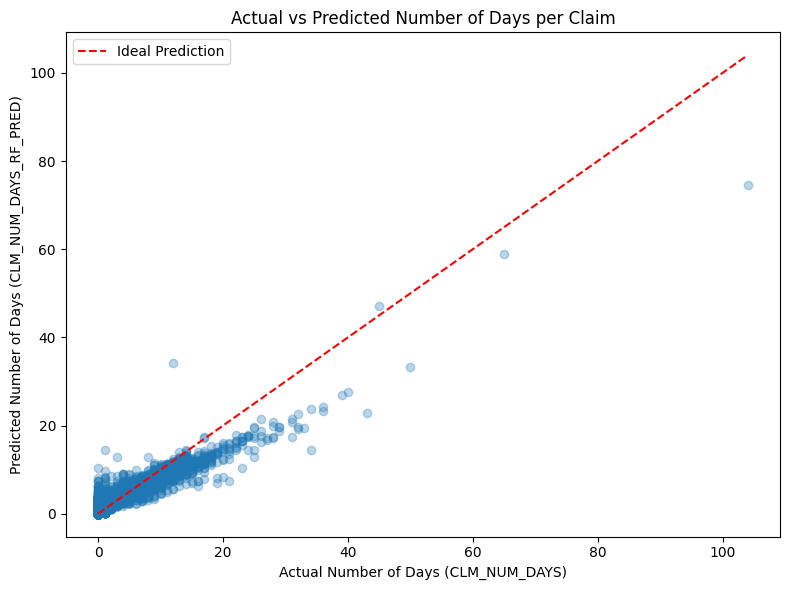

In [49]:
# plot the clm_num_days and the predicted num of days for each claim

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(train_df['CLM_NUM_DAYS'], train_df['CLM_NUM_DAYS_RF_PRED'], alpha=0.3)
plt.xlabel('Actual Number of Days (CLM_NUM_DAYS)')
plt.ylabel('Predicted Number of Days (CLM_NUM_DAYS_RF_PRED)')
plt.title('Actual vs Predicted Number of Days per Claim')
plt.plot([train_df['CLM_NUM_DAYS'].min(), train_df['CLM_NUM_DAYS'].max()],
         [train_df['CLM_NUM_DAYS'].min(), train_df['CLM_NUM_DAYS'].max()],
         color='red', linestyle='--', label='Ideal Prediction')
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
# check feature importances
import pandas as pd

importances = rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(importance_df)

# THESE DO SEEM A BIT ODD
# prncipal being really important makes sense
# cd1 being less important fits because it is often a copy of principal
# after that I would expect it mostly to be in number order. Why is it not?

                  feature  importance
25  PRNCPAL_DGNS_CD_TMEAN    0.419997
0      ICD_DGNS_CD1_TMEAN    0.048850
2      ICD_DGNS_CD3_TMEAN    0.047118
5      ICD_DGNS_CD6_TMEAN    0.042572
4      ICD_DGNS_CD5_TMEAN    0.041363
6      ICD_DGNS_CD7_TMEAN    0.039959
1      ICD_DGNS_CD2_TMEAN    0.039129
3      ICD_DGNS_CD4_TMEAN    0.037951
7      ICD_DGNS_CD8_TMEAN    0.036503
8      ICD_DGNS_CD9_TMEAN    0.033869
9     ICD_DGNS_CD10_TMEAN    0.030681
10    ICD_DGNS_CD11_TMEAN    0.029525
11    ICD_DGNS_CD12_TMEAN    0.022692
12    ICD_DGNS_CD13_TMEAN    0.020574
13    ICD_DGNS_CD14_TMEAN    0.019839
14    ICD_DGNS_CD15_TMEAN    0.017298
15    ICD_DGNS_CD16_TMEAN    0.015437
16    ICD_DGNS_CD17_TMEAN    0.014027
18    ICD_DGNS_CD19_TMEAN    0.010183
17    ICD_DGNS_CD18_TMEAN    0.009705
19    ICD_DGNS_CD20_TMEAN    0.007238
22    ICD_DGNS_CD23_TMEAN    0.004265
20    ICD_DGNS_CD21_TMEAN    0.003915
23    ICD_DGNS_CD24_TMEAN    0.003067
21    ICD_DGNS_CD22_TMEAN    0.002444
24    ICD_DG

In [51]:
# Now use IsolationForest on the residuals (difference between actual and predicted days)
# if the results is near -1 then it is an outlier

from sklearn.ensemble import IsolationForest
import numpy as np

# Prepare the feature: difference between actual and predicted days
train_diff_days_inpatient = train_df['CLM_NUM_DAYS'] - train_df['CLM_NUM_DAYS_RF_PRED']

# Reshape for IsolationForest
train_diff_reshape = train_diff_days_inpatient.values.reshape(-1, 1)

# Fit IsolationForest on the difference
iso_diff = IsolationForest(random_state=42, contamination='auto')
iso_diff.fit(train_diff_reshape)

# Get the decision function scores
train_decision_scores = iso_diff.decision_function(train_diff_reshape)

# Store the scores in the dataframe
train_df['CLM_NUM_DAYS_IFOREST_DIFF_SCORE'] = train_decision_scores

In [52]:
train_df[['BENE_ID', 'CLM_ID', 'CLM_NUM_DAYS', 'CLM_NUM_DAYS_RF_PRED', 'CLM_NUM_DAYS_IFOREST_DIFF_SCORE', 'PRNCPAL_DGNS_CD']].sort_values('CLM_NUM_DAYS_IFOREST_DIFF_SCORE', ascending=True)

,BENE_ID,CLM_ID,CLM_NUM_DAYS,CLM_NUM_DAYS_RF_PRED,CLM_NUM_DAYS_IFOREST_DIFF_SCORE,PRNCPAL_DGNS_CD
1010,-10000010285889,-10000931401781,104,74.600000,-0.336425,Z899
5346,-10000010278266,-10000931110987,34,14.374857,-0.332473,T50901A
11782,-10000010268234,-10000930639137,43,22.945000,-0.332473,T50901A
12579,-10000010267159,-10000930592287,50,33.320000,-0.330785,T50901A
2340,-10000010283477,-10000931310723,36,23.380000,-0.329100,T50901A
...,...,...,...,...,...,...
14423,-10000010264129,-10000930460558,0,0.000000,0.190002,M8000X
860,-10000010286190,-10000931409961,0,0.000000,0.190002,Z608
4426,-10000010280074,-10000931177594,0,0.000000,0.190002,S93409
3269,-10000010282387,-10000931260450,0,0.000000,0.190002,Z733


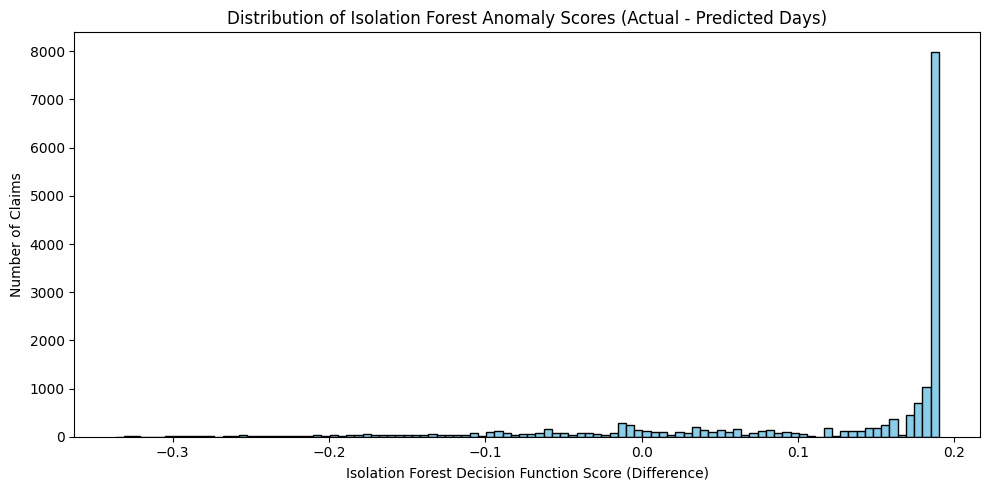

In [53]:
import matplotlib.pyplot as plt

# Visualize the Isolation Forest anomaly scores for the difference between actual and predicted days
plt.figure(figsize=(10, 5))
plt.hist(train_df['CLM_NUM_DAYS_IFOREST_DIFF_SCORE'], bins=100, color='skyblue', edgecolor='k')
plt.xlabel('Isolation Forest Decision Function Score (Difference)')
plt.ylabel('Number of Claims')
plt.title('Distribution of Isolation Forest Anomaly Scores (Actual - Predicted Days)')
plt.tight_layout()
plt.show()

# LETS WORK WITH THE TEST DATA
-------------------
--------------------

In [54]:
# add the principal diagnosis code TMEAN to the test set
test_df['PRNCPAL_DGNS_CD_TMEAN'] = test_df['PRNCPAL_DGNS_CD'].map(principal_code_tmean)

# Map the diagnosis columns to their TMEAN values
for col in diagnosis_cols:
    test_df[f'{col}_TMEAN'] = test_df[col].map(diag_code_Tmeans)

In [55]:
# use the random forest model to predict on the test set


rf_test_data = test_df[tmean_cols + ['PRNCPAL_DGNS_CD_TMEAN', 'CLM_NUM_DAYS']]

X_test = rf_test_data[tmean_cols + ['PRNCPAL_DGNS_CD_TMEAN']]
y_test = rf_test_data['CLM_NUM_DAYS']

# Predict on the same data and evaluate
y_test_pred = rf.predict(X_test)

# Add predictions to the DataFrame
test_df.loc[rf_test_data.index, 'CLM_NUM_DAYS_RF_PRED'] = y_test_pred

In [56]:
test_df

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,CLM_NUM_DAYS,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,...,ICD_DGNS_CD17_TMEAN,ICD_DGNS_CD18_TMEAN,ICD_DGNS_CD19_TMEAN,ICD_DGNS_CD20_TMEAN,ICD_DGNS_CD21_TMEAN,ICD_DGNS_CD22_TMEAN,ICD_DGNS_CD23_TMEAN,ICD_DGNS_CD24_TMEAN,ICD_DGNS_CD25_TMEAN,CLM_NUM_DAYS_RF_PRED
5537,-10000010277996,-10000931099569,2017-05-01 00:00:00,2017-05-01 00:00:00,0,T50901A,Z608,N181,E1121,T50901A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.350833
2937,-10000010282719,-10000931278929,2017-06-24 00:00:00,2017-06-24 00:00:00,0,Z608,Z608,Z733,F0280,N1830,...,1.148835,0.864066,0.857946,0.853781,0.601094,1.147247,0.609808,1.088907,1.141946,0.000000
11623,-10000010268671,-10000930659235,2015-07-25 00:00:00,2015-07-25 00:00:00,0,T148XX,T148XX,T7432X,P2830,G479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025000
5350,-10000010278249,-10000931110635,2015-08-24 00:00:00,2015-08-27 00:00:00,3,Z7682,Z940,Z733,Z608,D4959,...,1.236621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.506667
19717,-10000010256112,-10000930097957,2023-02-23 00:00:00,2023-02-23 00:00:00,0,S93409,S93409,Z733,P84,Z608,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.360000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18014,-10000010258512,-10000930205837,2017-12-09 00:00:00,2017-12-09 00:00:00,0,Z608,Z608,Z733,R931,I259,...,1.008506,1.169065,1.083580,1.101828,NaN,NaN,NaN,NaN,NaN,0.000000
16800,-10000010259846,-10000930274967,2015-06-22 00:00:00,2015-06-22 00:00:00,0,S51819,S51819,Z604,I252,I214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050000
14068,-10000010264641,-10000930487736,2021-04-14 00:00:00,2021-04-23 00:00:00,9,Z733,Z733,C3490,C3490,R931,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.187667
5557,-10000010277922,-10000931097881,2022-12-29 00:00:00,2022-12-29 00:00:00,0,S91319,S91319,Z733,E669,Z604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


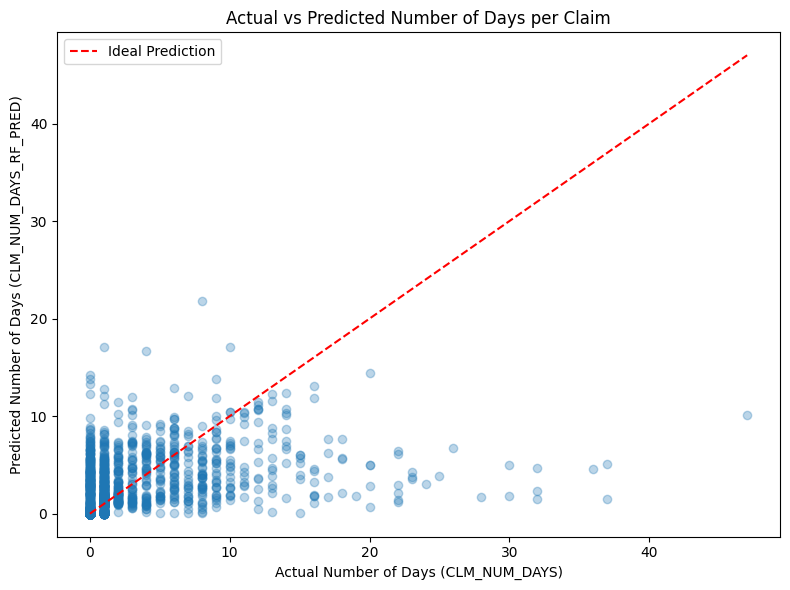

In [57]:
# plot the clm_num_days and the predicted num of days for each claim

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(test_df['CLM_NUM_DAYS'], test_df['CLM_NUM_DAYS_RF_PRED'], alpha=0.3)
plt.xlabel('Actual Number of Days (CLM_NUM_DAYS)')
plt.ylabel('Predicted Number of Days (CLM_NUM_DAYS_RF_PRED)')
plt.title('Actual vs Predicted Number of Days per Claim')
plt.plot([test_df['CLM_NUM_DAYS'].min(), test_df['CLM_NUM_DAYS'].max()],
         [test_df['CLM_NUM_DAYS'].min(), test_df['CLM_NUM_DAYS'].max()],
         color='red', linestyle='--', label='Ideal Prediction')
plt.legend()
plt.tight_layout()
plt.show()

In [58]:
# Now use IsolationForest on the residuals (difference between actual and predicted days)
# if the results is near -1 then it is an outlier

# Prepare the feature: difference between actual and predicted days
test_diff_days_inpatient = test_df['CLM_NUM_DAYS'] - test_df['CLM_NUM_DAYS_RF_PRED']

# Reshape for IsolationForest
test_diff_reshape = test_diff_days_inpatient.values.reshape(-1, 1)

# Get the decision function scores
test_decision_scores = iso_diff.decision_function(test_diff_reshape)

# Store the scores in the dataframe
test_df['CLM_NUM_DAYS_IFOREST_DIFF_SCORE'] = test_decision_scores

In [59]:
test_df[['BENE_ID', 'CLM_ID', 'CLM_NUM_DAYS', 'CLM_NUM_DAYS_RF_PRED', 'CLM_NUM_DAYS_IFOREST_DIFF_SCORE', 'PRNCPAL_DGNS_CD']].sort_values('CLM_NUM_DAYS_IFOREST_DIFF_SCORE', ascending=True)

,BENE_ID,CLM_ID,CLM_NUM_DAYS,CLM_NUM_DAYS_RF_PRED,CLM_NUM_DAYS_IFOREST_DIFF_SCORE,PRNCPAL_DGNS_CD
5405,-10000010278096,-10000931104693,47,10.1000,-0.336425,T50901A
4463,-10000010280012,-10000931175633,36,4.5775,-0.336425,T50901A
16150,-10000010261149,-10000930324590,32,4.6600,-0.336425,T50901A
10018,-10000010271351,-10000930774188,30,5.0300,-0.336425,T50901A
11352,-10000010269271,-10000930684140,32,1.4900,-0.336425,T50901A
...,...,...,...,...,...,...
3649,-10000010281930,-10000931240297,0,0.0000,0.190002,T7432X
5557,-10000010277922,-10000931097881,0,0.0000,0.190002,S91319
2973,-10000010282666,-10000931275417,0,0.0000,0.190002,Z608
2937,-10000010282719,-10000931278929,0,0.0000,0.190002,Z608


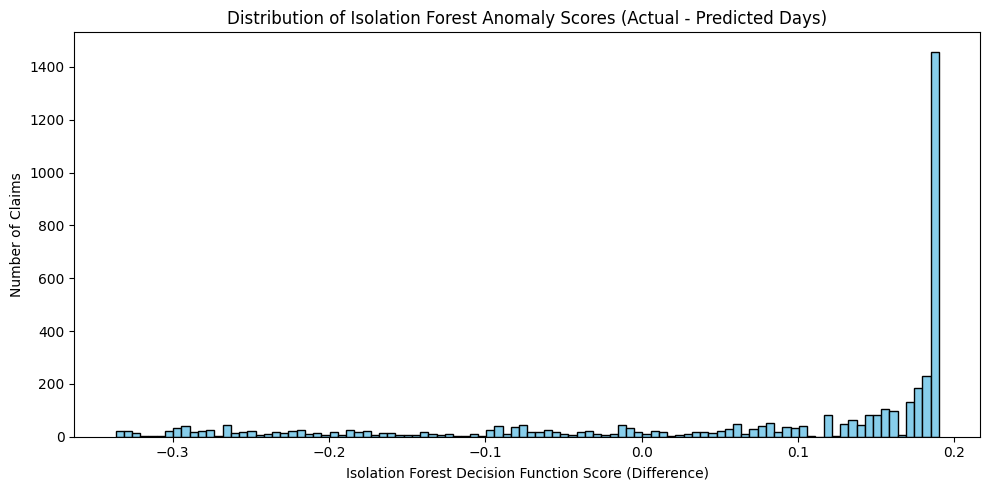

In [60]:
import matplotlib.pyplot as plt

# Visualize the Isolation Forest anomaly scores for the difference between actual and predicted days
plt.figure(figsize=(10, 5))
plt.hist(test_df['CLM_NUM_DAYS_IFOREST_DIFF_SCORE'], bins=100, color='skyblue', edgecolor='k')
plt.xlabel('Isolation Forest Decision Function Score (Difference)')
plt.ylabel('Number of Claims')
plt.title('Distribution of Isolation Forest Anomaly Scores (Actual - Predicted Days)')
plt.tight_layout()
plt.show()

In [61]:
# Test the prediction accuracy of the random forest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Mean Squared Error: {mse:.3f}")
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"R^2 Score: {r2:.3f}")

Mean Squared Error: 8.184
Root Mean Squared Error: 2.861
Mean Absolute Error: 1.022
R^2 Score: 0.226


In [62]:
import joblib
from pathlib import Path

# Get the full path of the parent directory
root = Path.cwd().parent
base_path = root / "server/models/"

base_path.mkdir(parents=True, exist_ok=True)

joblib.dump(rf, base_path / "rf-length-of-stay.pkl")
joblib.dump(iso_diff, base_path / "iso_diff-length-of-stay.pkl")

['c:\\Workspace\\hack2\\Hackathon25\\server\\models\\iso_diff-length-of-stay.pkl']